## O. Importy a načítanie datasetu


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix,  classification_report
from keras.utils.vis_utils import plot_model


In [ ]:
#Import datasetu
dataset = pd.read_csv('Churn_Modelling.csv', index_col='RowNumber')
dataset.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1. Príprava dát

In [ ]:
# rozdelenie datasetu na dáta a hodnoty True/False (0,1), ktoré odkazujú na to 
# či zákazník opustil banku alebo nie.
X_col = dataset.columns.tolist()[2:12]
y_col = dataset.columns.tolist()[-1:]
print('Dáta', X_col)
print('True/False', y_col)

Dáta ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
True/False ['Exited']


In [ ]:
# vytvorenie nummpy array z týchto stĺpcov
X = dataset[X_col].values 
y = dataset[y_col].values
X

array([[619, 'France', 'Female', ..., 1, 1, 101348.88],
       [608, 'Spain', 'Female', ..., 0, 1, 112542.58],
       [502, 'France', 'Female', ..., 1, 0, 113931.57],
       ...,
       [709, 'France', 'Female', ..., 0, 1, 42085.58],
       [772, 'Germany', 'Male', ..., 1, 0, 92888.52],
       [792, 'France', 'Female', ..., 1, 0, 38190.78]], dtype=object)

Ako môžeme vidieť tak dáta obsahujú aj kategorické premenné, ktoré treba nahradiť.

In [ ]:
encoder = LabelEncoder()
X[:,1] = encoder.fit_transform(X[:,1]) # zmena krajiny na hodnoty vhodné pre analýzu (0-France,1-Germany,2-Spain)
print('Krajina: ')
print(X[:,1])
X[:,2] = encoder.fit_transform(X[:,2]) # zmena pohlavia na hodnoty vhodné pre analýzu (0-Female, 1-Male)
print('Pohlavie: ')
print(X[:,2])

Krajina: 
[0 2 0 ... 0 1 0]
Pohlavie: 
[0 0 0 ... 0 1 0]


In [ ]:
# Pipeline - 
# StandardScaler - Normalizácia dát => zmena dát na jednu škálu "vyrovnanie dát", nakoľko dataset obsahuje 
# veľmi veľký rozsah hodnôť napr. výplaty sa pohybujú aj v státisícoch a tieto hodnoty by ovplyvnili výsledok
# ColumnTransformer - trieda pre selektívne aplikovanie úpravy údajov, teda môžeme použiť transformáciu udajov na kategoricke premenne
# OneHotEncoder - prevod celočíselných hodnôt na binárne 
# Country	->	Country	->	Spain	France	Germany
# Spain	  ->	  0	    ->	  1	    0	      0
# France	->	  1	    ->	  0	    1	      0
# France	->  	1     ->	  0	    1	      0
# Germany	->	  2	    ->	  0	    0	      1
pipeline = Pipeline(
    [('Categorizer', ColumnTransformer(
         [("Pohlavie", OneHotEncoder(categories='auto', drop='first'), [2]),
          ("Krajina", OneHotEncoder(categories='auto', drop='first'), [1])
         ], remainder='passthrough', n_jobs=1)),
    ('Normalizer', StandardScaler())
    ])

In [ ]:
X = pipeline.fit_transform(X)

In [ ]:
# Rozdelenie datasetu na testovacie a trénovacie dáta v pomere 30:70
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0) 

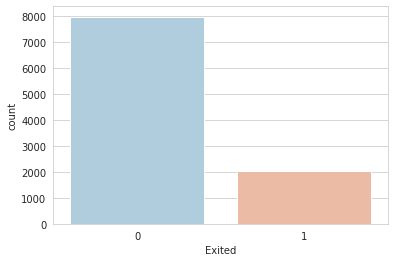

In [ ]:
data2 = dataset.drop(['CustomerId','Surname'],axis=1)
sns.set_style('whitegrid')
sns.countplot(x='Exited',data=data2,palette='RdBu_r')
# je vidieť, že dáta nie sú veľmi vyvážené.

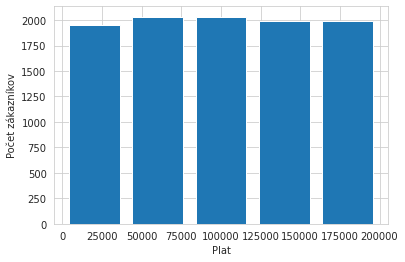

In [ ]:
plt.hist(data2.EstimatedSalary, bins=5
         , rwidth=0.8)
plt.xlabel('Plat')
plt.ylabel('Počet zákazníkov')
plt.show()
# graf ukazujúci plat a prislúchajúci počet zákazníkov.

##2. Vytvorenie NS

In [ ]:
# vytvárame sekvenčný model
classifier = Sequential()

In [ ]:
# Vstupná vrstva a prvá skrytá vrstva
# argumenty:
# prvé číslo je výstupna dimenzia - 6
# aktivačná funckia relu -  Jej predpis je R(z)=(0,z), takže záporné vstupy zmení na 0 a nezáporné hodnoty nechá bez zmeny
# input_shape = 11 (11 stĺpcov)
classifier.add(Dense(6, activation = 'relu',input_shape = (X_train.shape[1], )))
# pridanie nasledujúcej skrytej vrstvy
# prvé číslo je výstupna dimenzia - 6
classifier.add(Dense(6, activation = 'relu')) 
# pridatnie výstupnej vrstvy
# výstupná vrstva má 1 dimenziu
# nelineárna funkcia sigmoid, ktorej výstupom už nie je len celé číslo 0 alebo 1, ale reálne číslo z intervalu (0,1).
classifier.add(Dense(1, activation = 'sigmoid')) 
# výpis nášho kalsifikátora
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# optimalizátor - Algoritmus, ktorý chceme použiť na nájdenie optimálnej množiny váh v neurónových sieťach. Adam je veľmi účinná variácia stochastického gradientu.
# binary_crossentropy - porovnáva každú z predpovedaných pravdepodobností s výstupom skutočnej triedy, ktorý môže byť buď 0 alebo 1. Potom vypočíta skóre,
#                       ktoré pravdepodobnosti penalizuje, na základe vzdialenosti od očakávanej hodnoty. 
classifier.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
# fit - spustenie trénovania
# počet iterácií 100
# batch_size 32 - výber dát po čiastkach 
trenovanie = classifier.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.3, verbose=2)

Epoch 1/100
154/154 - 1s - loss: 0.6310 - accuracy: 0.6706 - val_loss: 0.5375 - val_accuracy: 0.7652
Epoch 2/100
154/154 - 0s - loss: 0.5049 - accuracy: 0.7863 - val_loss: 0.4822 - val_accuracy: 0.7986
Epoch 3/100
154/154 - 0s - loss: 0.4684 - accuracy: 0.7990 - val_loss: 0.4607 - val_accuracy: 0.8005
Epoch 4/100
154/154 - 0s - loss: 0.4504 - accuracy: 0.8022 - val_loss: 0.4469 - val_accuracy: 0.8024
Epoch 5/100
154/154 - 0s - loss: 0.4381 - accuracy: 0.8049 - val_loss: 0.4367 - val_accuracy: 0.8062
Epoch 6/100
154/154 - 0s - loss: 0.4282 - accuracy: 0.8086 - val_loss: 0.4289 - val_accuracy: 0.8100
Epoch 7/100
154/154 - 0s - loss: 0.4204 - accuracy: 0.8106 - val_loss: 0.4219 - val_accuracy: 0.8110
Epoch 8/100
154/154 - 0s - loss: 0.4129 - accuracy: 0.8137 - val_loss: 0.4160 - val_accuracy: 0.8138
Epoch 9/100
154/154 - 0s - loss: 0.4066 - accuracy: 0.8163 - val_loss: 0.4099 - val_accuracy: 0.8152
Epoch 10/100
154/154 - 0s - loss: 0.4004 - accuracy: 0.8182 - val_loss: 0.4045 - val_accura

##3. Vizualizácia

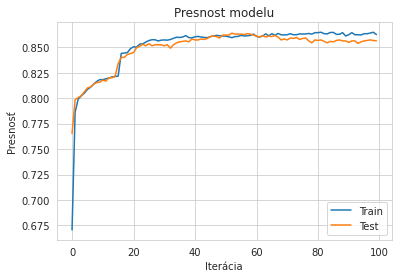

In [ ]:
plt.plot(trenovanie.history['accuracy'])
plt.plot(trenovanie.history['val_accuracy'])
plt.ylabel('Presnosť')
plt.xlabel('Iterácia')
plt.title('Presnost modelu')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()
# Graf presnosti modelu ukazuje 'accuracy' trenovacích a testovacích dát

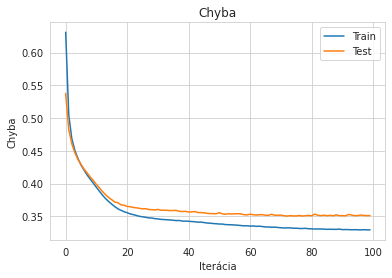

In [ ]:
plt.plot(trenovanie.history['loss']) 
plt.plot(trenovanie.history['val_loss']) 
plt.ylabel('Chyba') 
plt.xlabel('Iterácia')
plt.title('Chyba') 
plt.legend(['Train', 'Test'], loc='upper right') 
plt.show()
# Graf chýb modelu ukazuje chybovosť trenovacích a testovacích dát

In [ ]:
# Určenie pravdepodobnosti
# Použijeme teda medznú hodnotu 0,5 na označenie, či je pravdepodobné, že odíde alebo nie.
y_pred = classifier.predict(X_test)
print(y_pred[:5])
y_pred = (y_pred > 0.5).astype(int)
print(y_pred[:5])

[[0.30644718]
 [0.31477565]
 [0.11224836]
 [0.09692526]
 [0.09885946]]
[[0]
 [0]
 [0]
 [0]
 [0]]


In [ ]:
# vytvorenie confusion matrix
cm = confusion_matrix(y_test, y_pred)

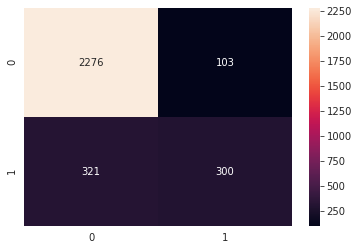

In [ ]:
# Heatmapa alebo teda confusion matrix znázornuje správnosť výsledkov
# 2276 odhadlo správne, že zákazník neodíde z banky avšak 103 zaradilo nesprávne.
# 300 odhadlo správne, že zákazník odíde z banky avšak 321 odhadlo nesprávne
# to značí, že aj keď je celková pravdepodovnosť vysoká tak pri takto nevyrovnaných dátach toto nie je úplne správny výsledok
sns.heatmap(cm,annot=True,fmt='g')

In [ ]:
# Ak sa pozrieme na report tak dúležitým prvkom je F1 score 
# F1- score hovorí o váženom priemere presnosti a opätovného zapamätania, kde skóre F1 dosahuje najlepšiu hodnotu pri 1 a najhoršie skóre pri 0.
# čiže dáta treba upraviť a vyrovnať score pre obe možnosti
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.91      2379
           1       0.74      0.48      0.59       621

    accuracy                           0.86      3000
   macro avg       0.81      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000



## 4. Zlepšenie výsledkov


In [ ]:
from sklearn.linear_model import LogisticRegression
# overenie výsledkov pomocou logistic regression
# je špecifický typ regresnej analýzy, pri ktorej je závislá premenná v nominálnej forme a nadobúda dve hodnoty, zvyčajne kódované ako  0 alebo 1.
# vidíme, že aj v tomto prípade je pre odchod znova nízke F1 score
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2379
           1       0.58      0.23      0.33       621

    accuracy                           0.81      3000
   macro avg       0.71      0.59      0.61      3000
weighted avg       0.78      0.81      0.77      3000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from imblearn.over_sampling import SMOTE
# SMOTE funguje tak, že vyberá príklady, ktoré sú blízko v priestore funkcií, kreslí čiaru medzi príkladmi v priestore funkcií a kreslí novú vzorku v bode pozdĺž tejto čiary.
# Konkrétne je najskôr vybraný náhodný príklad z triedy menšín. Potom sa nájde k najbližších susedov pre tento príklad (zvyčajne k = 5).
# Vyberie sa náhodne vybraný sused a v náhodne vybranom bode medzi dvoma príkladmi v priestore znakov sa vytvorí syntetický príklad.
smote = SMOTE(sampling_strategy='minority')
x_new, y_new = smote.fit_resample(X, np.ravel(y))
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.2, stratify=y_new)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# opätovné overenie pomocou logistickej regresie
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.71      0.71      1593
           1       0.71      0.70      0.70      1593

    accuracy                           0.70      3186
   macro avg       0.70      0.70      0.70      3186
weighted avg       0.70      0.70      0.70      3186



In [ ]:
# natrénovanie pomocou nových (vylepšených) dát
trenovanie2 = classifier.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.3, verbose=2)

Epoch 1/100
359/359 - 1s - loss: 0.4540 - accuracy: 0.7796 - val_loss: 0.4370 - val_accuracy: 0.7983
Epoch 2/100
359/359 - 1s - loss: 0.4424 - accuracy: 0.7879 - val_loss: 0.4362 - val_accuracy: 0.7983
Epoch 3/100
359/359 - 1s - loss: 0.4401 - accuracy: 0.7907 - val_loss: 0.4365 - val_accuracy: 0.7936
Epoch 4/100
359/359 - 1s - loss: 0.4389 - accuracy: 0.7913 - val_loss: 0.4364 - val_accuracy: 0.7920
Epoch 5/100
359/359 - 1s - loss: 0.4379 - accuracy: 0.7892 - val_loss: 0.4351 - val_accuracy: 0.7967
Epoch 6/100
359/359 - 1s - loss: 0.4370 - accuracy: 0.7924 - val_loss: 0.4347 - val_accuracy: 0.8006
Epoch 7/100
359/359 - 1s - loss: 0.4357 - accuracy: 0.7914 - val_loss: 0.4344 - val_accuracy: 0.8006
Epoch 8/100
359/359 - 1s - loss: 0.4351 - accuracy: 0.7899 - val_loss: 0.4346 - val_accuracy: 0.8006
Epoch 9/100
359/359 - 1s - loss: 0.4347 - accuracy: 0.7930 - val_loss: 0.4331 - val_accuracy: 0.7998
Epoch 10/100
359/359 - 1s - loss: 0.4337 - accuracy: 0.7936 - val_loss: 0.4330 - val_accura

In [ ]:
y_pred = classifier.predict(x_test)
print(y_pred[:5])
y_pred = (y_pred > 0.5).astype(int)
print(y_pred[:5])
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[0.07161346]
 [0.99940217]
 [0.01828739]
 [0.6480891 ]
 [0.04457983]]
[[0]
 [1]
 [0]
 [1]
 [0]]
[[1276  317]
 [ 329 1264]]


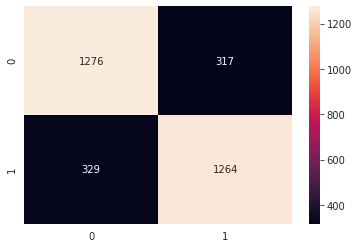

In [ ]:
# Heatmapa teraz zobratuje nové dáta a je jasné, že odhad bude po zlepšení o niečo presnejší za cenu nižšej celkovej presnosťi
# dáta su teraz viac vyrovnané, a tak aj pre zákazníkov, ktorí opustia banku máme väčšiu pravdepodobnosť úspechu.
sns.heatmap(cm,annot=True,fmt='g')

In [ ]:
# celková úspešnosť predikcie po vylepšení dát
print (((cm[0][0]+cm[1][1])*100)/(len(y_test)), '% dát bolo klasifikovaných správne')

79.72379158819837 % dát bolo klasifikovaných správne


In [ ]:
# ako môžeme vidieť dosiahli sme vysoké F1 score pre obe možnosti a teda NS je natrénovaná správne.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1593
           1       0.80      0.79      0.80      1593

    accuracy                           0.80      3186
   macro avg       0.80      0.80      0.80      3186
weighted avg       0.80      0.80      0.80      3186



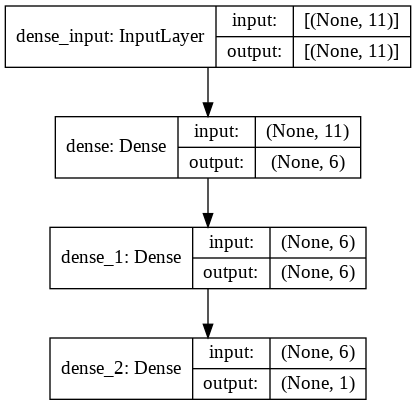

In [ ]:
# vykreslenie modelu
plot_model(classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)